In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wholesale-customers-data-set/Wholesale customers data.csv


In [3]:
df = pd.read_csv('/kaggle/input/wholesale-customers-data-set/Wholesale customers data.csv')
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


(   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
 0        2       3  12669  9656     7561     214              2674        1338
 1        2       3   7057  9810     9568    1762              3293        1776
 2        2       3   6353  8808     7684    2405              3516        7844
 3        1       3  13265  1196     4221    6404               507        1788
 4        2       3  22615  5410     7198    3915              1777        5185,
 None,
           Channel      Region          Fresh          Milk       Grocery  \
 count  440.000000  440.000000     440.000000    440.000000    440.000000   
 mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
 std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
 min      1.000000    1.000000       3.000000     55.000000      3.000000   
 25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
 50%      1.000000    3.000000    8504.000000   36

## EDA

/tmp/ipykernel_33/2288173553.py:4: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

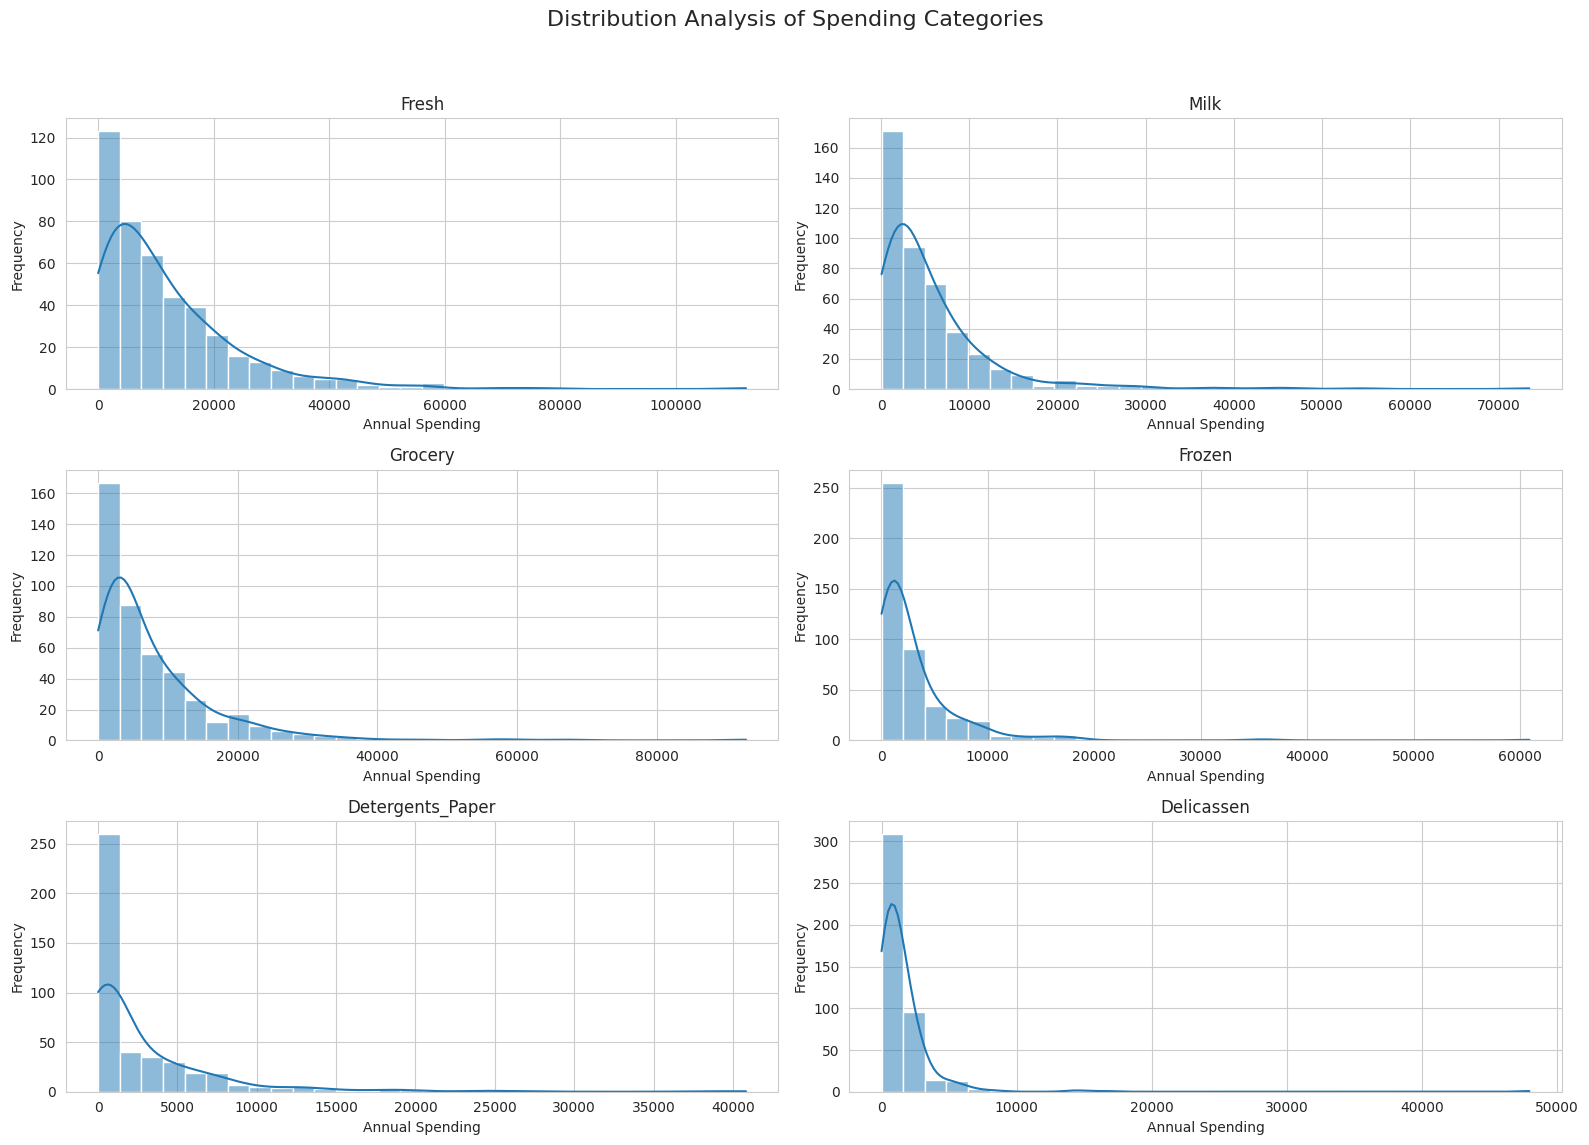

In [12]:
sns.set_style("whitegrid")

# Distribution analysis of each spending category
with pd.option_context('mode.use_inf_as_na', True):
    # Now let's create the histograms for each spending category
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Distribution Analysis of Spending Categories', fontsize=16)

    # Ensure that the plots are generated for each category
    for ax, category in zip(axes.flat, categories):
        sns.histplot(df[category], kde=True, ax=ax, bins=30)
        ax.set_title(category)
        ax.set_xlabel('Annual Spending')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

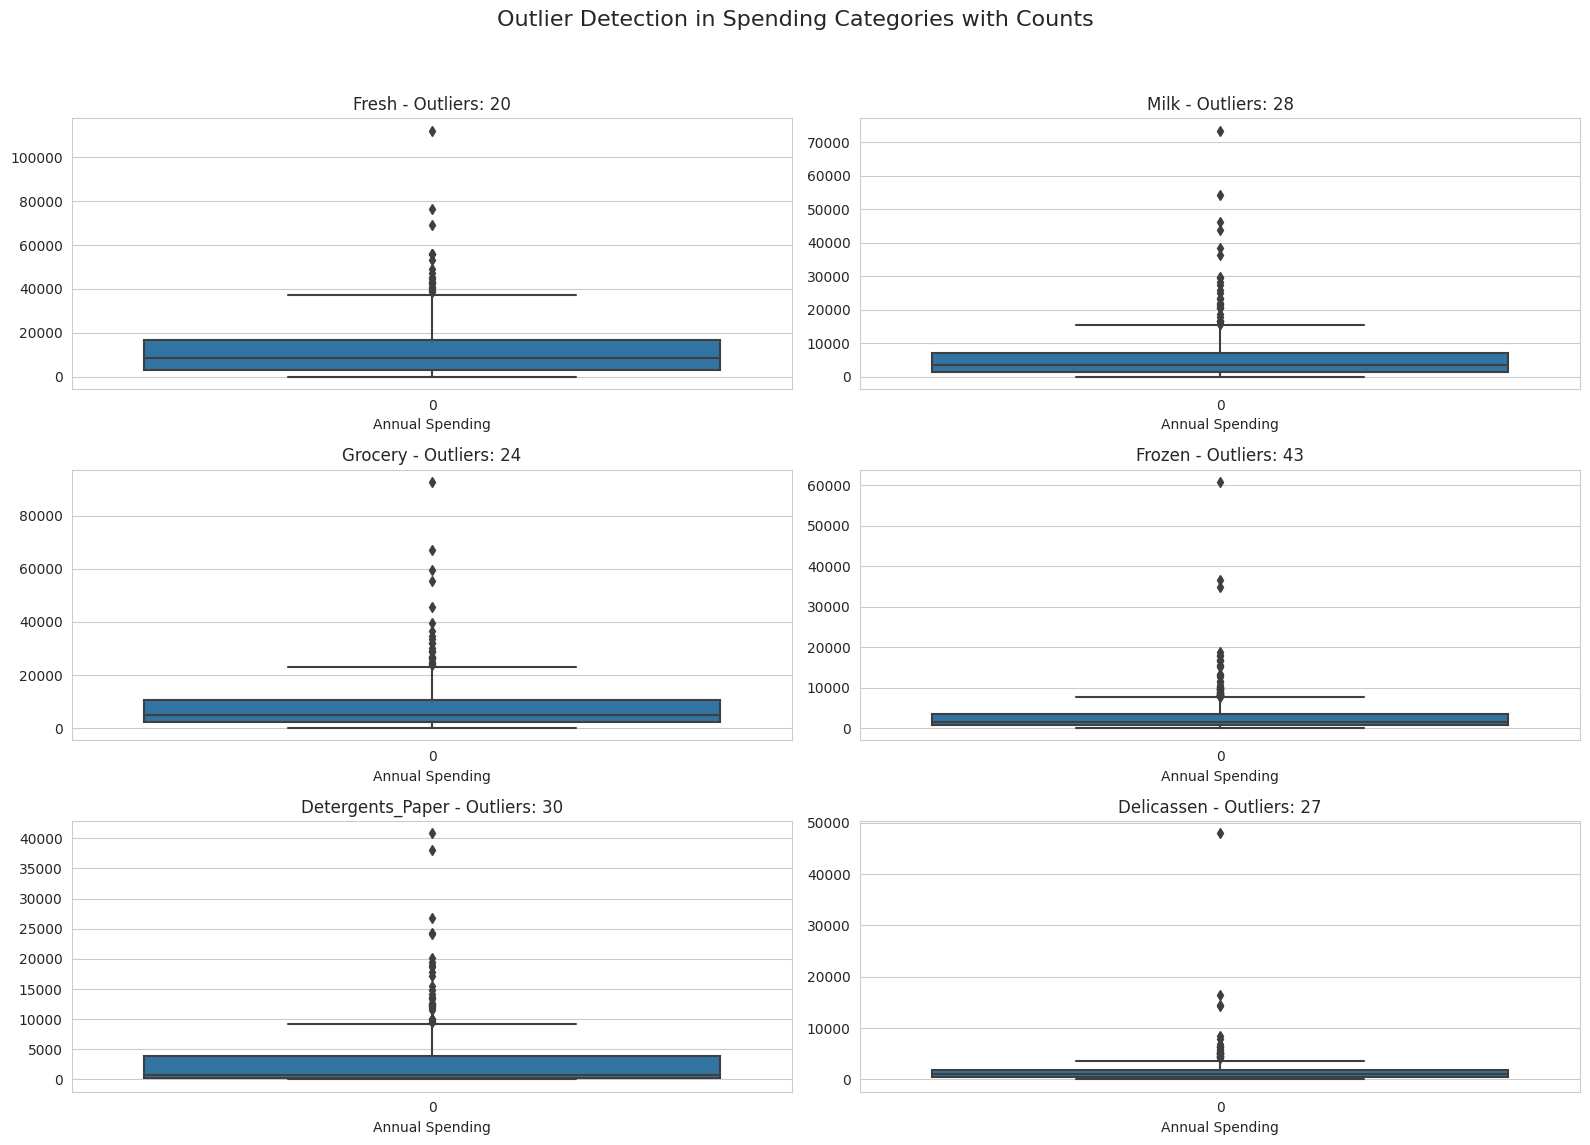

{'Fresh': 20,
 'Milk': 28,
 'Grocery': 24,
 'Frozen': 43,
 'Detergents_Paper': 30,
 'Delicassen': 27}

In [24]:
def calculate_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))
    return df[outlier_condition]

# Calculating the number of outliers for each category
outliers = {}
for category in categories:
    outliers[category] = calculate_outliers(df, category).shape[0]

# Creating box plots for each category
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Outlier Detection in Spending Categories with Counts', fontsize=16)

for ax, category in zip(axes.flat, categories):
    sns.boxplot(data=df[category], ax=ax)
    ax.set_title(f"{category} - Outliers: {outliers[category]}")
    ax.set_xlabel('Annual Spending')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

outliers

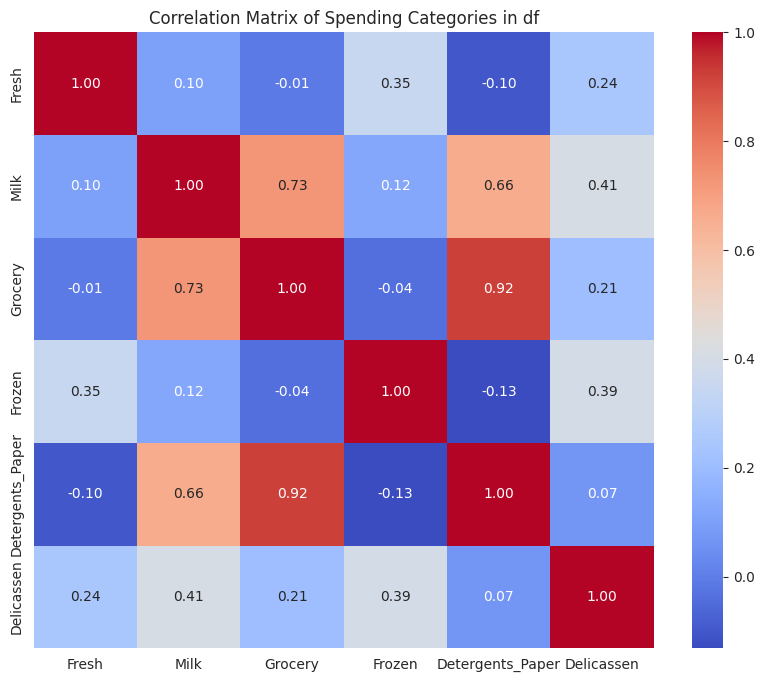

In [10]:
corr_matrix_df = df[categories].corr()

# Plotting the heatmap for df
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Spending Categories in df')
plt.show()

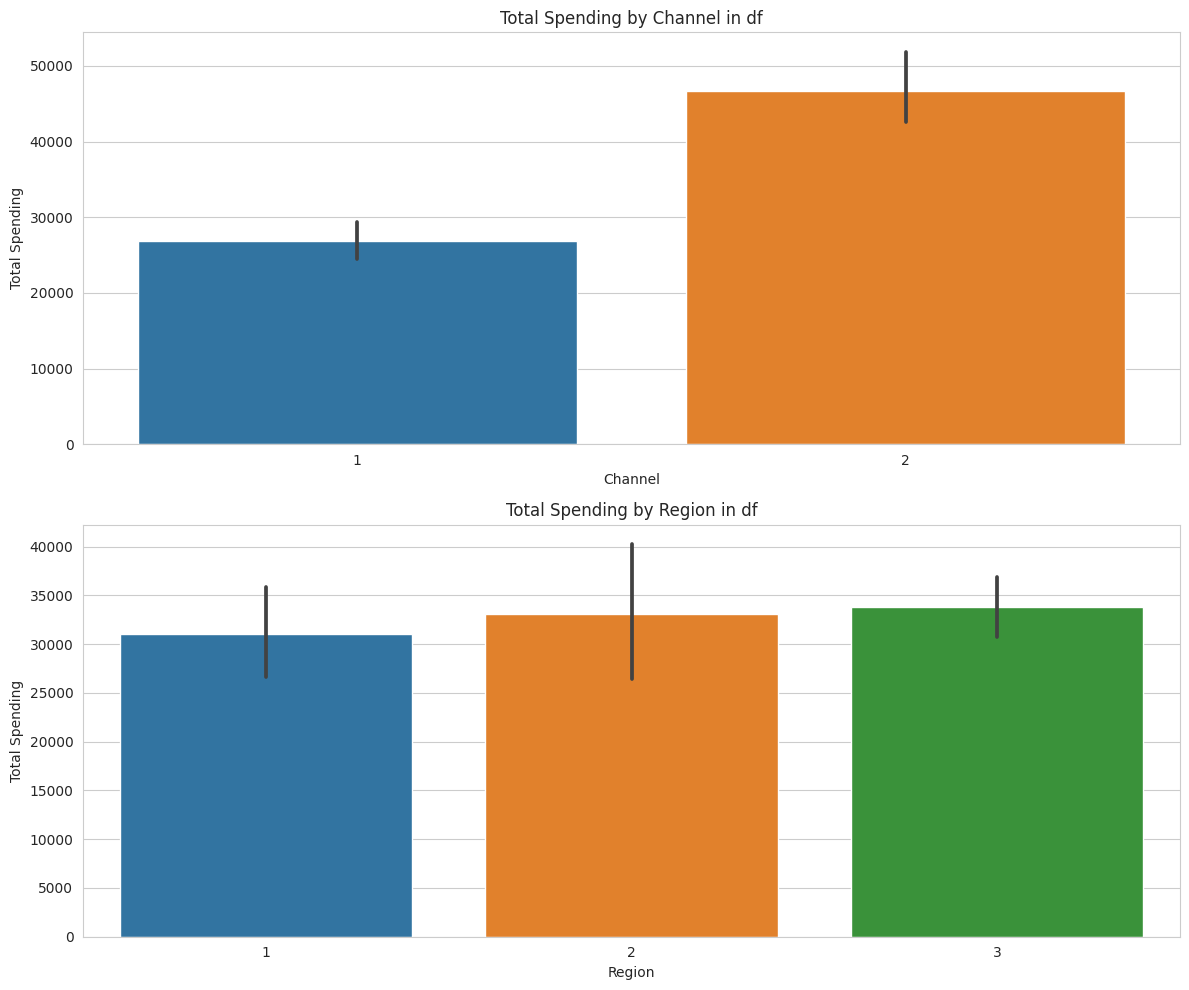

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Total Spending by Channel in df
sns.barplot(x='Channel', y='Total_Spending', data=df.assign(Total_Spending=df[categories].sum(axis=1)), ax=axes[0])
axes[0].set_title('Total Spending by Channel in df')
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Total Spending')

# Total Spending by Region in df
sns.barplot(x='Region', y='Total_Spending', data=df.assign(Total_Spending=df[categories].sum(axis=1)), ax=axes[1])
axes[1].set_title('Total Spending by Region in df')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Total Spending')

plt.tight_layout()
plt.show()

## Preprocessing

In [43]:
# removing outliers

for category in categories:
    Q1 = df[category].quantile(0.25)
    Q3 = df[category].quantile(0.75)
    IQR = Q3 - Q1
    # Keep only the ones that are within +3 IQRs of the quartiles (the normal range)
    df = df[~((df[category] < (Q1 - 1.5 * IQR)) | 
                                                      (df[category] > (Q3 + 1.5 * IQR)))]

In [44]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[categories])

## K-Means Clustering Modeling

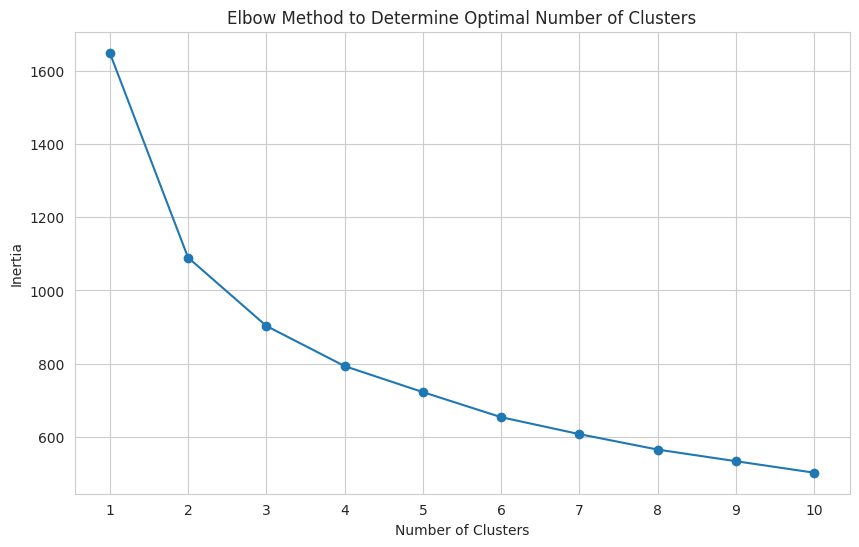

In [45]:
# Choosing the number of clusters using the elbow method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

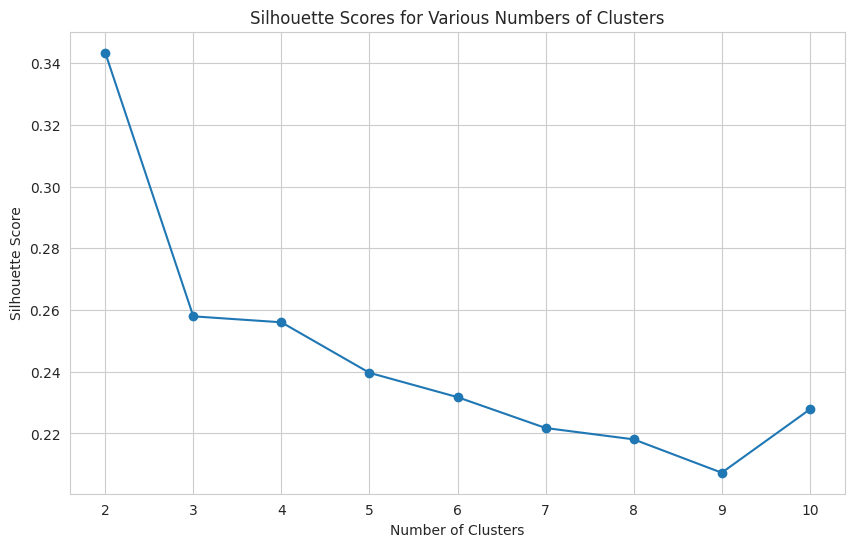

(2, 0.34336353470901976)

In [46]:
# Training K-Means++ model and evaluating with silhouette score
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.show()

# Finding the number of clusters with the highest silhouette score
best_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
best_k, best_score

In [47]:
# Training K-Means++ model with 6 clusters
kmeans_final = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans_final.fit(df_scaled)

# Assigning the cluster labels to the original dataframe
df['Cluster'] = kmeans_final.labels_

# Getting the silhouette score for the final model
final_silhouette_score = silhouette_score(df_scaled, kmeans_final.labels_)

# Number of customers in each cluster
cluster_counts = df['Cluster'].value_counts()

final_silhouette_score, cluster_counts

(0.23174608743550063,
 Cluster
 0    96
 5    40
 2    39
 3    36
 4    33
 1    31
 Name: count, dtype: int64)

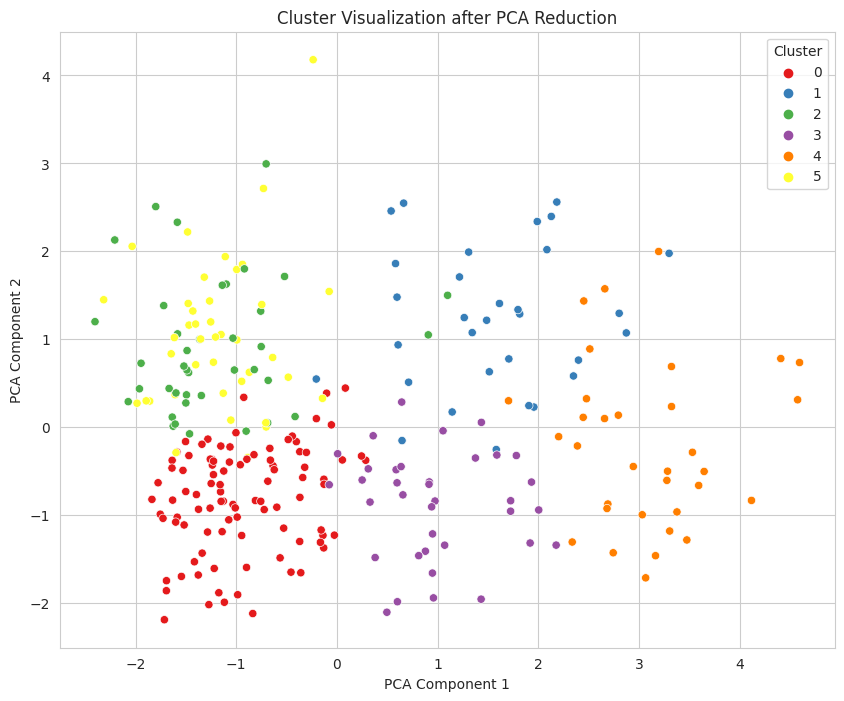

In [48]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Creating a scatter plot of the two PCA components and coloring by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df['Cluster'], palette='Set1')
plt.title('Cluster Visualization after PCA Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## Conclusion and Future Work

Our machine learning analysis successfully segmented the wholesale customers into distinct groups based on their spending behavior across various product categories.

We identified specific segments that demonstrate significantly higher spending in certain categories, which can be targeted with tailored marketing strategies.

Understanding these customer segments allows for more efficient resource allocation, optimized product stocking, and personalized marketing, potentially leading to increased customer satisfaction and sales.

uture work could explore integrating additional data sources, such as customer demographics or transaction frequency, to enrich the segmentation analysis.